In [62]:
import numpy as np
import pandas as pd
import xarray as xr
import GPy
import geopandas
import geoplot
import random
import os
import shutil
import time
import scipy.stats as stats 

from IPython.display import clear_output

from math import pi
from datetime import datetime
from collections import OrderedDict

import torch
from torch.utils.data import TensorDataset, DataLoader 

from utils import *
from runmanager import *
from experiment import *

from shapely.geometry import box, mapping
import cartopy.crs as ccrs

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
%matplotlib inline

### Import data

In [4]:
# Import dataframe
path = '..\..\PhD/data/pickle/df_stations_all_nonzero.pkl'
st = pd.read_pickle(path)

# Replace NaN values from observed precipitation columns in observations Dataframe so that observed precipitation column can be read as float 

st['Prec'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
st['Prec'].replace(r'.', np.nan, regex=True, inplace=True)
st.dropna(inplace=True)

start="1998-01-01"
end="2007-12-31"

st = st[st['Date'].between(start,end)]

In [5]:
st['BC_diff'] = st['model_precipitation'] - st['wrf_bcp']
aux = st.groupby('Station').sum()
aux.reset_index(inplace=True)
bc_stations = aux['Station'][aux['BC_diff']!=0].unique()

### K-fold train/validation split

In [7]:

flag=1
if flag:
    st_names = bc_stations 
else:
    st_names = st['Station'].unique()

In [8]:
# Random selection of locations for train and test
np.random.shuffle(st_names)

split = round(len(st_names) * 0.8)

st_names_train = list(st_names[:split])
st_names_test = list(st_names[split:])

print("%s stations used for training, %s used for testing" % (len(st_names_train), len(st_names_test)))

26 stations used for training, 6 used for testing


In [10]:
kf_split_5 = {}

kf = KFold(n_splits=5,shuffle=True)
kf.get_n_splits(st_names)

for i, (train_index, test_index) in enumerate(kf.split(st_names)):
    kf_split_5[f'k{i}'] = {f'train': st_names[train_index],
                           f'test' : st_names[test_index]
                          }

### Prepare data

In [11]:
data = {}

predictors = ['model_precipitation',
              'Z',
              'doy_sin',
              'doy_cos',
              'X',
              'Y',]

predictant = ['Prec']

X = st[predictors].to_numpy()

x_mean = X.mean(axis=0) 
x_std = X.std(axis=0)
#x_min = X.min(axis=0) 
#x_max = X.max(axis=0) 

for i in range(len(kf_split_5)):

    data[f'X_train_{i}'] = (st[st['Station'].isin(kf_split_5[f'k{i}']['train'])][predictors].to_numpy() - x_mean) / x_std
    data[f'X_test_{i}'] = (st[st['Station'].isin(kf_split_5[f'k{i}']['test'])][predictors].to_numpy() - x_mean) / x_std

    data[f'Y_train_{i}'] = st[st['Station'].isin(kf_split_5[f'k{i}']['train'])][predictant].to_numpy()
    data[f'Y_test_{i}'] = st[st['Station'].isin(kf_split_5[f'k{i}']['test'])][predictant].to_numpy()

### Train model with single run

In [13]:
d=6

r = np.random.randint(5)
X_train, Y_train, X_test, Y_test = data[f'X_train_{r}'], data[f'Y_train_{r}'], data[f'X_test_{r}'], data[f'Y_test_{r}']


train_tensor_x = torch.Tensor(X_train[:,:d]) # transform to torch tensor
train_tensor_y = torch.Tensor(Y_train[:,:d])

train_dataset = TensorDataset(train_tensor_x,train_tensor_y) # create your dataset

test_tensor_x = torch.Tensor(X_test[:,:d]) # transform to torch tensor
test_tensor_y = torch.Tensor(Y_test[:,:d])

test_dataset = TensorDataset(test_tensor_x,test_tensor_y) # create your dataset

In [14]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [15]:
model = MLP(in_channels=d, 
            hidden_channels=10, 
            likelihood_fn='b2gmm'
           )

print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 136


In [16]:
mean_train_losses = []
mean_valid_losses = []

epochs = 10

optimizer = torch.optim.Adam(model.parameters(), lr=.01)

for epoch in range(epochs):
    train_losses, valid_losses = train_epoch(model, optimizer, train_loader, valid_loader, print_progress=True, epoch=epoch)
    
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))

epoch : 1, train loss : 1.2578, valid loss : 1.1570
epoch : 2, train loss : 1.1722, valid loss : 1.1704
epoch : 3, train loss : 1.1682, valid loss : 1.1321
epoch : 4, train loss : 1.1671, valid loss : 1.0926
epoch : 5, train loss : 1.1664, valid loss : 1.1325
epoch : 6, train loss : 1.1657, valid loss : 1.1175
epoch : 7, train loss : 1.1656, valid loss : 1.1152
epoch : 8, train loss : 1.1652, valid loss : 1.1148
epoch : 9, train loss : 1.1631, valid loss : 1.1180
epoch : 10, train loss : 1.1620, valid loss : 1.1168


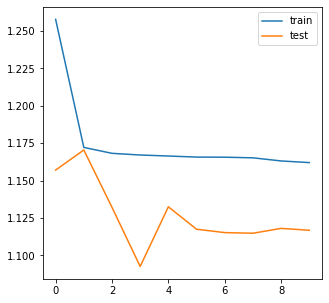

In [17]:
plt.figure(figsize=(5,5))
plt.plot(mean_train_losses)
plt.plot(mean_valid_losses)
plt.legend(["train","test"])
#plt.ylim([1,1.5])

### Train model with different hyperparameters

In [130]:
params = OrderedDict(
    lr = [.01]
    ,batch_size = [128]
    ,likelihood_fn = ['bgmm','b2gmm']
    ,hidden_channels = [10]
    ,k = [0,1,2,3,4]
)

epochs = 20

In [131]:
m = RunManager()
predictions={}
for l in params['likelihood_fn']:
    predictions[l] = {} 

for run in RunBuilder.get_runs(params):
    
    d=6
    
    network = MLP(in_channels=d, 
            hidden_channels=run.hidden_channels, 
            likelihood_fn=run.likelihood_fn
            )
    
    train_tensor_x = torch.Tensor(data[f'X_train_{run.k}'][:,:d]) # transform to torch tensor
    train_tensor_y = torch.Tensor(data[f'Y_train_{run.k}'][:,:d]) # transform to torch tensor
    train_dataset = TensorDataset(train_tensor_x,train_tensor_y) # create training dataset

    test_tensor_x = torch.Tensor(data[f'X_test_{run.k}'][:,:d]) # transform to torch tensor
    test_tensor_y = torch.Tensor(data[f'Y_test_{run.k}'][:,:d]) # transform to torch tensor
    test_dataset = TensorDataset(test_tensor_x,test_tensor_y) # create test dataset
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=run.batch_size, shuffle=True)
    valid_loader = DataLoader(dataset=test_dataset, batch_size=run.batch_size, shuffle=False)
    
    optimizer = torch.optim.Adam(network.parameters(), lr=run.lr)
    
    change_folder = True
    if change_folder:
        experiment_name = f'{run}'
        wd = WorkingDirectory(generate_root(experiment_name))
    
    m.begin_run(run, network, train_loader)
    
    train_losses = []
    valid_losses = []
    
    for epoch in range (epochs):
        
        m.begin_epoch()
        
        train_loss, valid_loss = train_epoch(network, 
                                             optimizer, 
                                             train_loader, 
                                             valid_loader, 
                                             epoch=epoch, 
                                             print_progress=False)

        m.epoch_loss = train_loss
        m.epoch_val_loss = valid_loss
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        #m.track_loss(loss)
            
        m.end_epoch()
        
        save_as_best = True if valid_loss == min(valid_losses) else False
        save_checkpoint(wd,network.state_dict(),is_best=save_as_best)
    
        PATH = os.path.join(wd.root,'e_%s_loss_%.3f.pth.tar' % (epoch, valid_loss))
        torch.save(network.state_dict(), PATH)
        
    load_best = True
    if load_best:
        network.load_state_dict(torch.load(os.path.join(wd.root,'model_best.pth.tar')))
        
    with torch.no_grad():
        outputs = network(test_tensor_x)
    
    st_test = build_results_df(st, 
              outputs, 
              st_names_test=kf_split_5[f'k{run.k}']['test'], 
              model=network)
    
    predictions[run.likelihood_fn][f'k{run.k}'] = st_test
    
    SAVEPATH = os.path.join(wd.root, "st_test.pkl")
    st_test.to_pickle(SAVEPATH)
    
    m.end_run()    
    
m.save('results')     

,run,epoch,loss,valid_loss,epoch duration,run duration,lr,batch_size,likelihood_fn,hidden_channels,k
0,1,1,1.226033,1.196376,1.773642,1.775643,0.01,128,bgmm,10,0
1,1,2,1.155402,1.193101,1.760617,3.564677,0.01,128,bgmm,10,0
2,1,3,1.150777,1.205011,1.793686,5.391394,0.01,128,bgmm,10,0
3,1,4,1.149314,1.187987,1.768145,7.187564,0.01,128,bgmm,10,0
4,1,5,1.149704,1.180071,1.886839,9.111436,0.01,128,bgmm,10,0
...,...,...,...,...,...,...,...,...,...,...,...
195,10,16,1.119417,1.251110,2.303138,38.442052,0.01,128,b2gmm,10,4
196,10,17,1.119238,1.253944,2.338768,40.819856,0.01,128,b2gmm,10,4
197,10,18,1.119209,1.266194,2.356296,43.211183,0.01,128,b2gmm,10,4
198,10,19,1.119012,1.256530,2.328130,45.576348,0.01,128,b2gmm,10,4


In [ ]:
for k in predictions.keys():
    for i in range(5):
        predictions[k][f'k{i}']['k_fold'] = i
        if i == 0:
            predictions[k]['k_all'] = predictions[k][f'k{i}']
        else:
            predictions[k]['k_all'] = predictions[k]['k_all'].append(predictions[k][f'k{i}'])

In [129]:
df = pd.read_csv('results.csv', index_col='Unnamed: 0')
df.sort_values('valid_loss')

,run,epoch,loss,valid_loss,epoch duration,run duration,lr,batch_size,likelihood_fn,hidden_channels,k
94,7,5,1.166625,1.099344,2.222573,11.255999,0.01,128,b2gmm,10,1
91,7,2,1.173885,1.102089,2.225085,4.470198,0.01,128,b2gmm,10,1
90,7,1,1.219936,1.103017,2.208080,2.209081,0.01,128,b2gmm,10,1
132,9,13,1.162800,1.103354,2.269113,30.288263,0.01,128,b2gmm,10,3
24,2,10,1.182943,1.103675,1.770641,18.629236,0.01,128,bgmm,10,1
...,...,...,...,...,...,...,...,...,...,...,...
68,5,9,1.127181,1.265725,1.774662,17.197937,0.01,128,bgmm,10,4
63,5,4,1.131650,1.266568,1.900780,7.512954,0.01,128,bgmm,10,4
67,5,8,1.127180,1.269324,1.808691,15.390246,0.01,128,bgmm,10,4
60,5,1,1.194401,1.273551,1.812688,1.814690,0.01,128,bgmm,10,4


### Histograms of predicted parameter values 

In [ ]:
with torch.no_grad():
    inputs = test_dataset.tensors[0]
    outputs = model(inputs)
    
    n = outputs.shape[1]
    
    fig, ax = plt.subplots(1,n, figsize=(25, 5), sharex=False, sharey=False)
    
    if model.likelihood=='bgmm':
        variable = ['pi', 'alpha', 'beta']
        
    elif model.likelihood=='b2gmm': 
        variable = ['pi', 'alpha1', 'alpha2', 'beta1', 'beta2', 'q']
        
    for i in range(n):
        ax[i].hist(outputs[:,i].numpy())
        ax[i].title.set_text('%s (mean: %.2f, min: %.2f)' % (variable[i], 
                                                             outputs[:,i].mean(), 
                                                             outputs[:,i].min()))
        

### Sample from 2-Gamma mixture model and plot

In [ ]:
%%time
k = 1
bins = 1000
hist_max = 50
r = np.random.randint(outputs.shape[0], size=k)
print(r)
dist = gmm_fn(pi=outputs[r,0],
            alpha1=outputs[r,1],
            alpha2=outputs[r,2],
            beta1=outputs[r,3],
            beta2=outputs[r,4],
            q=outputs[r,5],
            )

plt.figure(figsize=(15,5))
plt.plot(np.linspace(0,hist_max,bins),(torch.histc(dist.sample([1000000]), bins=bins, min=0, max=hist_max)))
plt.plot(dist.mean,np.zeros(k),'or')
plt.plot(test_tensor_y[r],np.zeros(k),'xk',ms=10)
plt.show()

### Placeholder

In [ ]:
interval=5

flag = 0
if flag:

    while True:

        x = np.linspace (0, 100, 200) 
        r = np.random.randint(len(inputs))
        print(r)

        pi = outputs[r,0]
        a = outputs[r,1]
        rate = outputs[r,2]

        y1 = stats.gamma.cdf(x, a=a, scale=1/rate) #a is alpha, loc is beta???

        mu = stats.gamma.mean(a=a, scale=1/rate)
        median = stats.gamma.median(a=a, scale=1/rate)
        mixture_median = stats.gamma.ppf((0.5 - pi) / (1 - pi), a=a, scale=1/rate) if pi < 0.5 else 0
        mixture_mean = (1-pi) * mu

        print("mean: %.2f" % mu)
        print("median: %.2f" % median)
        print("mixture median: %.2f" % mixture_median)
        print("mixture mean: %.2f" % mixture_mean)

        modelled = inputs[r,0]*x_std[0] + x_mean[0]
        observed = tensor_y[r,0]

        if modelled > 0:

            #mu = a/rate if pi<0.5 else 0

            plt.plot(0,pi,"oy", label="pi = %.2f" % pi)

            plt.plot(mu, 0, "or", mfc="white", label="mu = %.2f" % mu)
            plt.plot(median, 0, "xr", label="median = %.2f" % median)  
            plt.plot(mixture_median, 0, "ok", mfc="white", label="mixture median = %.2f" % mixture_median)  
            plt.plot(mixture_mean, 0, "^k", label="mixture median = %.2f" % mixture_mean)  

            plt.plot(modelled, 0, "x", label="WRF = %.2f" % modelled)

            plt.plot(observed, 0, "xg", label="observed = %.2f" % observed)
            plt.plot(x, pi + (1-pi)*y1, "y-", label=(r'$\alpha=%.2f, \beta=%.2f$') % (a, rate))

            plt.ylim([-0.05,1])
            plt.xlim([-0.2, max([1,modelled,observed,mu])*1.20])
            plt.legend(loc="upper right")
            plt.show()

            time.sleep(interval)

        else:
            pass

        clear_output(wait=True)

### Time series 

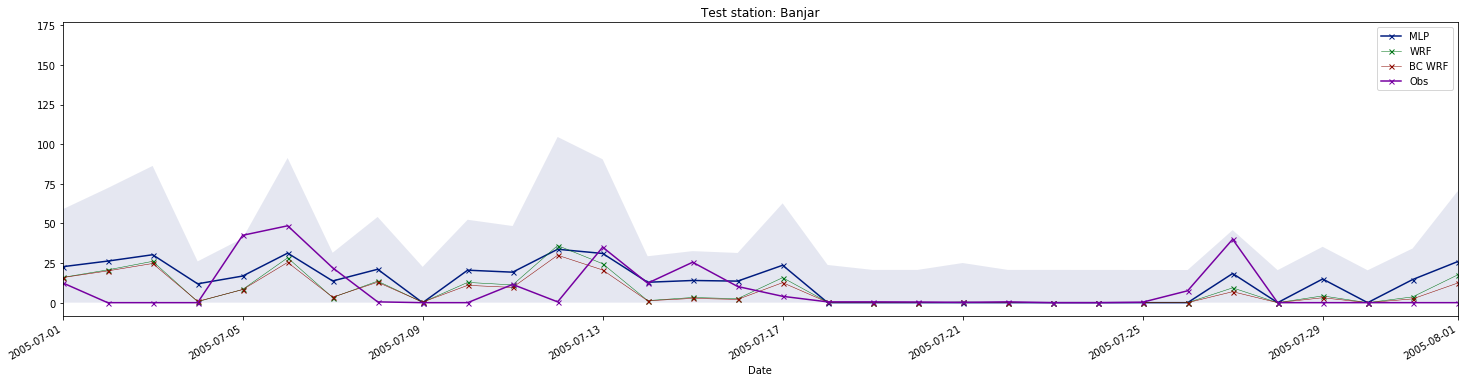

In [122]:
likelihood_fn = 'bgmm'
p=0.05
st_test = predictions[likelihood_fn]['k_all']

####################

st_names_test = st_test['Station'].unique()

r = np.random.randint(len(st_names_test))
rand_test_st = st_names_test[r]

st_test_r = st_test[st_test['Station']==rand_test_st].copy()

#print(rand_test_st)

#station_x = st_test['X'].unique()[0]
#station_y = st_test['Y'].unique()[0]

#print(station_x, station_y)

date = st_test_r['Date'].values #[(st_test['X']==station_x) & (st_test['Y']==station_y)].values
prec = st_test_r['Prec'].values #[(st_test['X']==station_x) & (st_test['Y']==station_y)].values

st_test_r.set_index('Date', inplace=True)

st_test_r['low_ci'] = st_test_r.apply(mixture_percentile, axis=1, args=(p, likelihood_fn))
st_test_r['high_ci'] = st_test_r.apply(mixture_percentile, axis=1, args=(1-p, likelihood_fn))

####################

msize = 5
lwidth = 0.5

plt.style.use('seaborn-dark-palette')

plt.figure(figsize=(25,6))

st_test_r['magnitude'].plot(
            marker='x',markersize=msize,linewidth=lwidth+1, label='MLP')#,mfc='blue',mec='blue')

st_test_r['model_precipitation'].plot(
            marker='x',markersize=msize,linewidth=lwidth, label='WRF')#,mfc='blue',mec='blue')

st_test_r['wrf_bcp'].plot(
            marker='x',markersize=msize,linewidth=lwidth, label='BC WRF')#,mfc='blue',mec='blue')

st_test_r['Prec'].plot(
            marker='x',markersize=msize,linewidth=lwidth+1, label='Obs')#,mfc='blue',mec='blue')

plt.fill_between(x=date,
                y1=st_test_r['low_ci'], 
                y2=st_test_r['high_ci'],
                alpha=0.1)

plt.title (f"Test station: {rand_test_st}")
#plt.xlim([start_time,end_time])
xmin = "2005-07-01"
xmax = "2005-08-01"
plt.xlim([datetime.strptime(xmin,"%Y-%m-%d"),          
          datetime.strptime(xmax,"%Y-%m-%d")])

plt.legend()
#plt.ylim([-5,50])
plt.show()

### Summary of results

In [124]:
#for rand_test_st in st_names_test:
likelihood_fn = 'b2gmm'
st_test = predictions[likelihood_fn]['k_all']

st_test_summary = st_test.groupby('Station').mean()

for rand_test_st in st_test['Station'].unique():
    
    st_test_r = st_test[st_test['Station']==rand_test_st].copy()
    st_test_r.set_index('Date', inplace=True)
    
    #st_test_r['se_wrf'] = (st_test_r['model_precipitation'] - st_test_r['Prec'])**2
    #st_test_r['se_bcp'] = (st_test_r['wrf_bcp'] - st_test_r['Prec'])**2
    #st_test_r['se_mlp'] = (st_test_r['magnitude'] - st_test_r['Prec'])**2
    
    #st_test_r['e_wrf'] = (st_test_r['model_precipitation'] - st_test_r['Prec'])
    #st_test_r['e_bcp'] = (st_test_r['wrf_bcp'] - st_test_r['Prec'])
    #st_test_r['e_mlp'] = (st_test_r['magnitude'] - st_test_r['Prec'])
    
    zero_mask = st_test_r['Prec']==0
    nonzero_mask = st_test_r['Prec']>20
    
    print("All Days ¦ Station : %s ¦ WRF : %.1f ¦ REG : %.1f ¦ MLP : %.1f ¦ Imp(REG/WRF) : %.2f%% ¦ Imp(MLP/WRF) : %.2f%%" %
          (rand_test_st,
           st_test_r['se_wrf'].mean(),
           st_test_r['se_bcp'].mean(),
           st_test_r['se_mlp'].mean(),
           100 - st_test_r['se_bcp'].mean()/st_test_r['se_wrf'].mean()*100,
           100 - st_test_r['se_mlp'].mean()/st_test_r['se_wrf'].mean()*100,
          )
         )
    
    print("Dry Days ¦ Station : %s ¦ WRF : %.1f ¦ REG : %.1f ¦ MLP : %.1f ¦ Imp(REG/WRF) : %.2f%% ¦ Imp(MLP/WRF) : %.2f%%" %
          (rand_test_st,
           st_test_r['se_wrf'][zero_mask].mean(),
           st_test_r['se_bcp'][zero_mask].mean(),
           st_test_r['se_mlp'][zero_mask].mean(),
           100 - st_test_r['se_bcp'][zero_mask].mean()/st_test_r['se_wrf'][zero_mask].mean()*100,
           100 - st_test_r['se_mlp'][zero_mask].mean()/st_test_r['se_wrf'][zero_mask].mean()*100,
          )
         )
    
    print("Wet Days ¦ Station : %s ¦ WRF : %.1f ¦ REG : %.1f ¦ MLP : %.1f ¦ Imp(REG/WRF) : %.2f%% ¦ Imp(MLP/WRF) : %.2f%%" %
          (rand_test_st,
           st_test_r['se_wrf'][nonzero_mask].mean(),
           st_test_r['se_bcp'][nonzero_mask].mean(),
           st_test_r['se_mlp'][nonzero_mask].mean(),
           100 - st_test_r['se_bcp'][nonzero_mask].mean()/st_test_r['se_wrf'][nonzero_mask].mean()*100,
           100 - st_test_r['se_mlp'][nonzero_mask].mean()/st_test_r['se_wrf'][nonzero_mask].mean()*100,
          )
         )
    
    print("==============================================================================================================================")

All Days ¦ Station : Pandoh ¦ WRF : 175.7 ¦ REG : 161.8 ¦ MLP : 108.3 ¦ Imp(REG/WRF) : 7.91% ¦ Imp(MLP/WRF) : 38.37%
Dry Days ¦ Station : Pandoh ¦ WRF : 30.5 ¦ REG : 31.2 ¦ MLP : 19.5 ¦ Imp(REG/WRF) : -2.12% ¦ Imp(MLP/WRF) : 36.03%
Wet Days ¦ Station : Pandoh ¦ WRF : 1567.0 ¦ REG : 1469.7 ¦ MLP : 1268.8 ¦ Imp(REG/WRF) : 6.21% ¦ Imp(MLP/WRF) : 19.03%
All Days ¦ Station : Janjehl ¦ WRF : 208.9 ¦ REG : 183.1 ¦ MLP : 131.8 ¦ Imp(REG/WRF) : 12.34% ¦ Imp(MLP/WRF) : 36.92%
Dry Days ¦ Station : Janjehl ¦ WRF : 39.2 ¦ REG : 31.9 ¦ MLP : 20.7 ¦ Imp(REG/WRF) : 18.64% ¦ Imp(MLP/WRF) : 47.28%
Wet Days ¦ Station : Janjehl ¦ WRF : 2271.3 ¦ REG : 2038.5 ¦ MLP : 1910.5 ¦ Imp(REG/WRF) : 10.25% ¦ Imp(MLP/WRF) : 15.89%
All Days ¦ Station : Karsog ¦ WRF : 91.0 ¦ REG : 92.1 ¦ MLP : 71.4 ¦ Imp(REG/WRF) : -1.17% ¦ Imp(MLP/WRF) : 21.58%
Dry Days ¦ Station : Karsog ¦ WRF : 26.1 ¦ REG : 28.0 ¦ MLP : 16.4 ¦ Imp(REG/WRF) : -7.15% ¦ Imp(MLP/WRF) : 37.30%
Wet Days ¦ Station : Karsog ¦ WRF : 1133.9 ¦ REG : 1117.4 ¦ M

In [ ]:
st_test_summary;

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(st_test_r['Prec'], st_test_r['se_mlp'],'o',ms=4,label="MLP")
plt.plot(st_test_r['Prec'], st_test_r['se_wrf'],'x',ms=4,label="WRF")

plt.legend()

#plt.ylim([-0,20000])
plt.show()

In [72]:
import geopandas as gpd
st_test_summary['se_mlp_ratio'] = 1 - st_test_summary['se_mlp']/st_test_summary['se_wrf']
st_test_summary['se_reg_ratio'] = 1 - st_test_summary['se_bcp']/st_test_summary['se_wrf']
gdf = geopandas.GeoDataFrame(
    st_test_summary, geometry=geopandas.points_from_xy(st_test_summary.X, st_test_summary.Y))

In [73]:
path = '..\..\PhD/gis/exports/beas_watershed.shp'
beas_watershed = geopandas.read_file(path)

path = '..\..\PhD/gis/exports/sutlej_watershed.shp'
sutlej_watershed = geopandas.read_file(path)

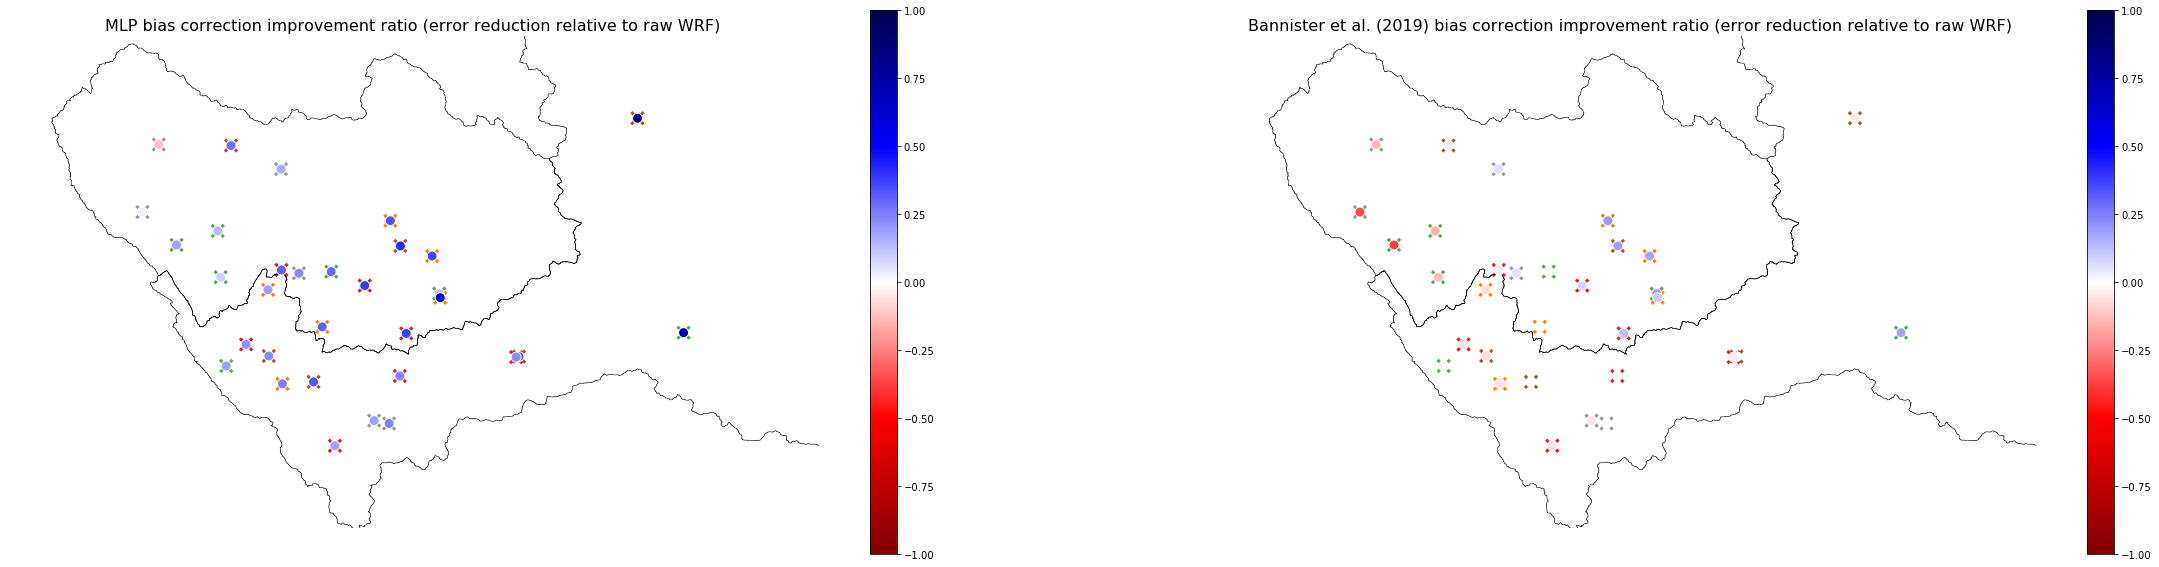

In [116]:
fig, axes = plt.subplots(1, 2, figsize=(40,10))
color_map = plt.cm.get_cmap('seismic').reversed()
margin = 0.25
#plt.colorbar(plt.cm.ScalarMappable(cmap=color_map), ax=ax)

for ax in axes:
    gdf.plot(ax=ax, column='k_fold', legend=False, cmap='Set1', markersize=150, marker="x", linewidth=3)
    beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    ax.set_xlim(gdf.X.min() - margin*(gdf.X.max() - gdf.X.min()), gdf.X.max() + margin*(gdf.X.max() - gdf.X.min()))
    ax.set_ylim(gdf.Y.min() - margin*(gdf.Y.max() - gdf.Y.min()), gdf.Y.max() + margin*(gdf.Y.max() - gdf.Y.min()))
    #ax.set_ylabel(" ")
    #ax.set_xlabel(" ")
    ax.set_axis_off()

#plt.scatter(gdf.X, gdf.Y, c=gdf.se_mlp_ratio, cmap=color_map)
gdf.plot(ax=axes[0], column='se_mlp_ratio',legend=True, edgecolor = 'white',  cmap=color_map,  markersize=100, vmin=-1, vmax=1)
axes[0].set_title('MLP bias correction improvement ratio (error reduction relative to raw WRF)', fontsize=16)
gdf.plot(ax=axes[1], column='se_reg_ratio',legend=True, edgecolor = 'white', cmap=color_map,  markersize=100, vmin=-1, vmax=1)
axes[1].set_title('Bannister et al. (2019) bias correction improvement ratio (error reduction relative to raw WRF)', fontsize=16)


#plt.tight_layout()
#plt.show()
plt.savefig(likelihood_fn+'.png')

'b2gmm'